<h1><b>Skin Cancer: Malignant vs. Benign</b></h1>


# **Load data from Google Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/Data/data.zip

Streaming output truncated to the last 5000 lines.
  inflating: melanoma_cancer_dataset/train/malignant/melanoma_10210.jpg  
  inflating: melanoma_cancer_dataset/train/malignant/melanoma_10211.jpg  
  inflating: melanoma_cancer_dataset/train/malignant/melanoma_10212.jpg  
  inflating: melanoma_cancer_dataset/train/malignant/melanoma_10213.jpg  
  inflating: melanoma_cancer_dataset/train/malignant/melanoma_10214.jpg  
  inflating: melanoma_cancer_dataset/train/malignant/melanoma_10215.jpg  
  inflating: melanoma_cancer_dataset/train/malignant/melanoma_10216.jpg  
  inflating: melanoma_cancer_dataset/train/malignant/melanoma_10217.jpg  
  inflating: melanoma_cancer_dataset/train/malignant/melanoma_10218.jpg  
  inflating: melanoma_cancer_dataset/train/malignant/melanoma_10219.jpg  
  inflating: melanoma_cancer_dataset/train/malignant/melanoma_10220.jpg  
  inflating: melanoma_cancer_dataset/train/malignant/melanoma_10221.jpg  
  inflating: melanoma_cancer_dataset/train/malignant/melanoma

## **Import libraries**

In [3]:
import tensorflow as tf
import numpy as np
import os
import pandas as pd
import cv2
import numpy as np
import keras
from tensorflow.keras import layers

print(tf.__version__)
tf.random.set_seed(2345)
np.random.seed(1234)
np.set_printoptions(precision=4)
AUTO = tf.data.experimental.AUTOTUNE

import warnings
warnings.filterwarnings("ignore")

from matplotlib import pyplot as plt
import matplotlib as mpl

2.15.0


In [4]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
  metrics =  ['loss', 'accuracy']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], '-bo', label='Train')
    plt.plot(history.epoch, history.history['val_'+metric], '-r^', linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.,1])
    else:
      plt.ylim([0,1])

    plt.legend()

In [5]:
import glob

folder_path = '/content/melanoma_cancer_dataset/train'

images_path = glob.glob(folder_path +'/*/*.jpg')

labels = [i.split('/')[-2] for i in images_path]

df = pd.DataFrame({'image_path': images_path, 'label': labels})

df.head()

,image_path,label
0,/content/melanoma_cancer_dataset/train/maligna...,malignant
1,/content/melanoma_cancer_dataset/train/maligna...,malignant
2,/content/melanoma_cancer_dataset/train/maligna...,malignant
3,/content/melanoma_cancer_dataset/train/maligna...,malignant
4,/content/melanoma_cancer_dataset/train/maligna...,malignant


## **Split the data into three sets: training, validation, and testing**

In [6]:
from sklearn.model_selection import train_test_split
import numpy as np

train_df,test_df = train_test_split(df, test_size=0.2, random_state=0, stratify=df['label'].values)
train_df,val_df = train_test_split(train_df, test_size=0.2, random_state=0, stratify=train_df['label'].values)

In [7]:
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

## **Plotting the distribution of labels**

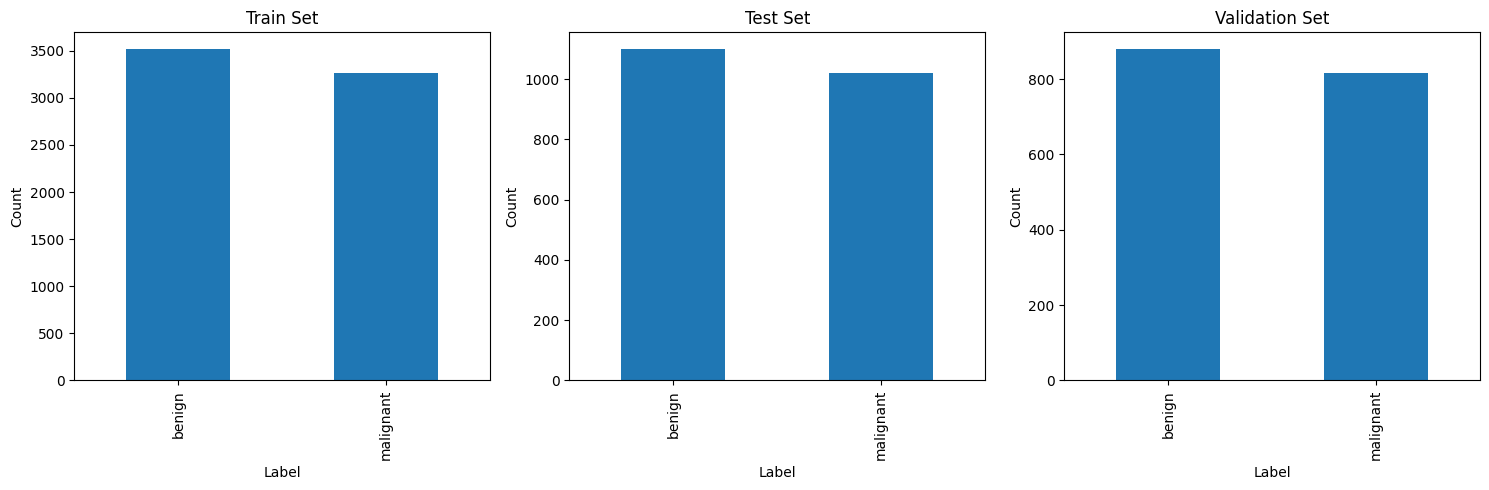

In [8]:
plt.figure(figsize=(15, 5))

# Plot for train_df
plt.subplot(1, 3, 1)
train_df['label'].value_counts().plot(kind='bar')
plt.title('Train Set')
plt.xlabel('Label')
plt.ylabel('Count')

# Plot for df_test
plt.subplot(1, 3, 2)
test_df['label'].value_counts().plot(kind='bar')
plt.title('Test Set')
plt.xlabel('Label')

plt.ylabel('Count')

# Plot for df_val
plt.subplot(1, 3, 3)
val_df['label'].value_counts().plot(kind='bar')
plt.title('Validation Set')
plt.xlabel('Label')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

## **Display images with colored labels**

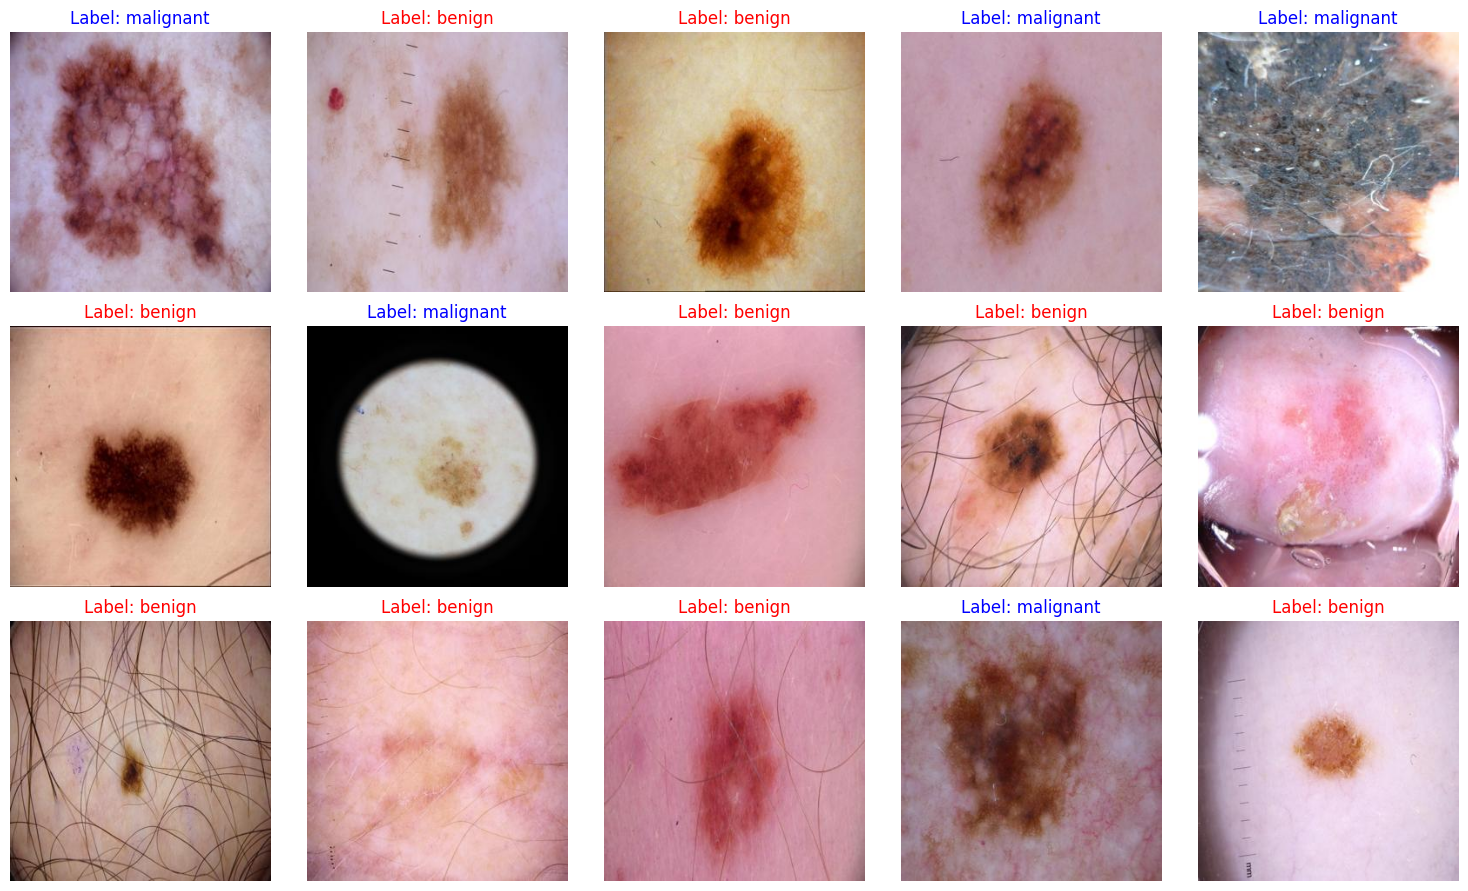

In [9]:
def display_images_colored(df, num_images=15, images_per_row=5):
    plt.figure(figsize=(15, 9))
    label_colors = {
        'benign': 'red',
        'malignant': 'blue'
    }

    num_rows = (num_images + images_per_row - 1) // images_per_row  # Calculate the number of rows

    for i in range(num_images):
        # Get the image path from the DataFrame
        image_path = df['image_path'].iloc[i]

        # Read and display the image using OpenCV
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Get the label and corresponding color
        label = df['label'].iloc[i]
        color = label_colors.get(label, 'gray')  # Default to gray if label not found

        plt.subplot(num_rows, images_per_row, i + 1)
        plt.imshow(image)
        plt.title("Label: {}".format(df['label'].iloc[i]), color=color)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

display_images_colored(train_df, num_images=15, images_per_row=5)


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    shear_range=10,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)
test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)

In [11]:
train_ds = train_datagen.flow_from_dataframe( # split data loader
    dataframe=train_df,
    x_col='image_path',
    y_col='label',
    target_size=(240, 240),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=True,
    seed=42,
)

val_ds = test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image_path',
    y_col='label',
    target_size=(240, 240),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=False,
    seed=42,
)

test_ds = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='label',
    target_size=(240, 240),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=False,
)

Found 6787 validated image filenames belonging to 2 classes.
Found 1697 validated image filenames belonging to 2 classes.
Found 2121 validated image filenames belonging to 2 classes.


In [12]:
for i, (image_batch, label_batch) in enumerate(train_ds):
  print("Image batch shape: ", image_batch.shape)
  print("Labe batch shape: ", label_batch.shape)
  if i == 0: break

Image batch shape:  (64, 240, 240, 3)
Labe batch shape:  (64, 2)


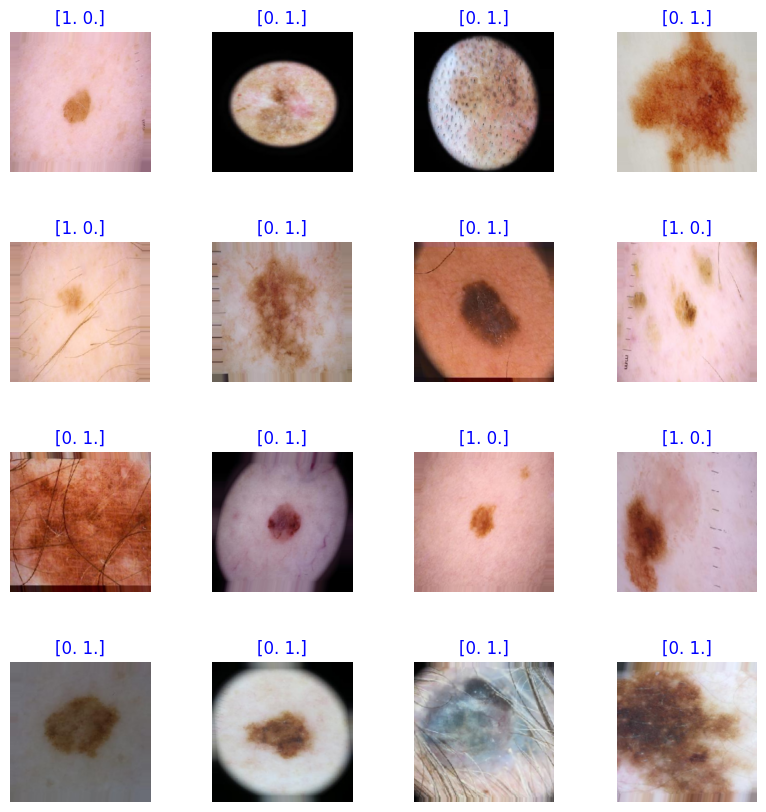

In [13]:
plt.figure(figsize=(10,10))
plt.subplots_adjust(hspace=0.5)
for n in range(16):
  plt.subplot(4, 4, n+1)
  plt.imshow(image_batch[n].astype('uint8'))
  plt.title(label_batch[n], color="blue")
  plt.axis('off')

# **Train model**

1e-06 1.0053900726920275e-06


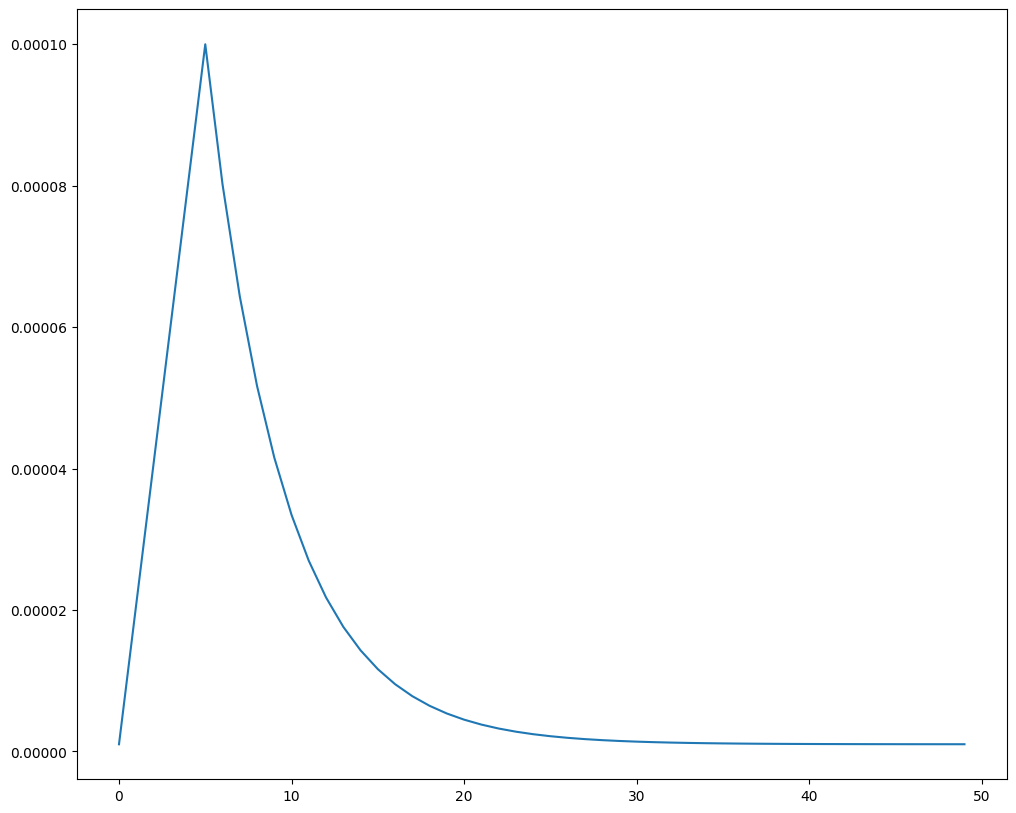

In [14]:
EPOCHS = 50
start_lr = 0.000001
min_lr = 0.000001
max_lr = 0.0001
rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

def lrfn(epoch):
    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        if epoch < rampup_epochs:
            lr = (max_lr - start_lr)/rampup_epochs * epoch + start_lr
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        else:
            lr = (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr
        return lr
    return lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay)

lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, [lrfn(x) for x in rng]) # vẽ biểu đồ biểu diễn sự thay đổi của learning)rate theo số epoch
print(y[0], y[-1]) # giá trị của learning rate tại epoch đầu tiên và epoch cuối cùng

In [15]:
IMAGE_SIZE = 240
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)
input_layer = tf.keras.layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="input_layer")

base_model = tf.keras.applications.EfficientNetB1(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
base_model.trainable = False

global_average_layer = tf.keras.layers.GlobalAveragePooling2D(name='gap')
dpo = tf.keras.layers.Dropout(0.2, name="dropout")
prediction_layer = tf.keras.layers.Dense(2, activation='softmax', name='prediction_output')

27018416/27018416 [==============================] - 0s 0us/step


In [16]:
inputs = base_model.input
x = base_model(inputs , training=False) # Freeze the weights of the base model to prevent updating them during the training process.
x = global_average_layer(x)
x=dpo(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 efficientnetb1 (Functional  (None, 8, 8, 1280)        6575239   
 )                                                               
                                                                 
 gap (GlobalAveragePooling2  (None, 1280)              0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 prediction_output (Dense)   (None, 2)                 2562      
                                                                 
Total params: 6577801 (25.09 MB)
Trainable params: 2562 (10.0

# **Transfer to head**

In [17]:
# fine-tuning from block6i_add
base_model.trainable = False
print('number of trainable vars', len(model.trainable_variables))

number of trainable vars 2


In [18]:
filepath="ckpt_transfer_on_head/epochs_{epoch:03d}-val_acc-{val_accuracy:.3f}.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=2, mode='min', save_best_only=True)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    verbose=1,
    patience=3,
    mode='min',
    restore_best_weights=True)


model.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [19]:
import time
start_time = time.time()
print('[*] Start transfer learning')
history = model.fit(train_ds,validation_data=val_ds, epochs=10, callbacks=[checkpoint])

final_accuracy = history.history["val_accuracy"][-5:]
print("FINAL ACCURACY MEAN-5: ", np.mean(final_accuracy))
print("TRAINING TIME: ", time.time() - start_time, " sec")

[*] Start transfer learning
Epoch 1/10
107/107 [==============================] - ETA: 0s - loss: 0.5168 - accuracy: 0.7623
Epoch 1: val_loss improved from inf to 0.39561, saving model to ckpt_transfer_on_head/epochs_001-val_acc-0.864.h5
107/107 [==============================] - 135s 1s/step - loss: 0.5168 - accuracy: 0.7623 - val_loss: 0.3956 - val_accuracy: 0.8639
Epoch 2/10
107/107 [==============================] - ETA: 0s - loss: 0.3949 - accuracy: 0.8412
Epoch 2: val_loss improved from 0.39561 to 0.33969, saving model to ckpt_transfer_on_head/epochs_002-val_acc-0.880.h5
107/107 [==============================] - 110s 1s/step - loss: 0.3949 - accuracy: 0.8412 - val_loss: 0.3397 - val_accuracy: 0.8798
Epoch 3/10
107/107 [==============================] - ETA: 0s - loss: 0.3447 - accuracy: 0.8612
Epoch 3: val_loss improved from 0.33969 to 0.31259, saving model to ckpt_transfer_on_head/epochs_003-val_acc-0.889.h5
107/107 [==============================] - 111s 1s/step - loss: 0.3447

In [20]:
results = model.evaluate(test_ds, verbose=1)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

34/34 [==============================] - 7s 215ms/step - loss: 0.2381 - accuracy: 0.9128
    Test Loss: 0.23814
Test Accuracy: 91.28%


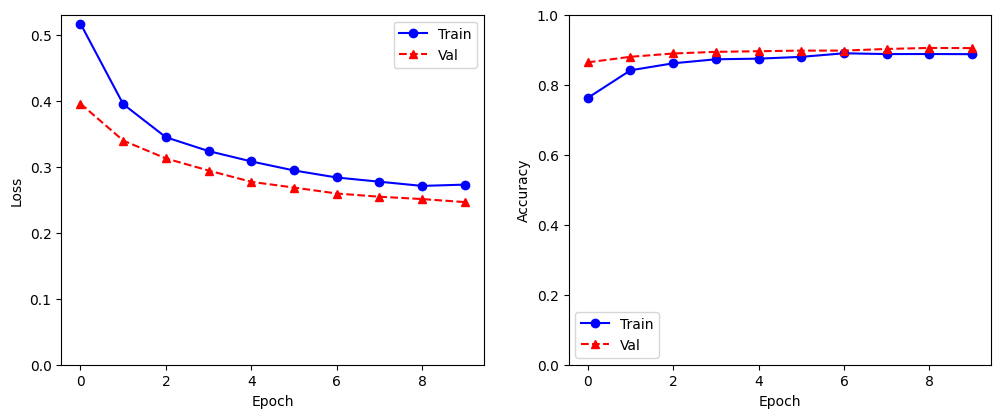

In [21]:
plot_metrics(history)

# **Fine-tuninng**

In [22]:
base_model.trainable = True
print('number of trainable vars', len(model.trainable_variables))

number of trainable vars 301


In [23]:
filepath="ckpts/epochs_{epoch:03d}-val_acc-{val_accuracy:.3f}.h5"

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=2, save_best_only=True, mode='min')

import time
start_time = time.time()
print('[*] Start finetuning')
history_ft = model.fit(train_ds,
                       validation_data=val_ds,
                       epochs=50,
                       initial_epoch=history.epoch[-1],
                       callbacks=[lr_callback, early_stopping, checkpoint])

final_accuracy = history_ft.history["val_accuracy"][-5:]
print("FINAL ACCURACY MEAN-5: ", np.mean(final_accuracy))
print("TRAINING TIME: ", time.time() - start_time, " sec")

[*] Start finetuning

Epoch 10: LearningRateScheduler setting learning rate to 4.155040000000001e-05.
Epoch 10/50
107/107 [==============================] - ETA: 0s - loss: 0.2627 - accuracy: 0.8926
Epoch 10: val_loss improved from inf to 0.24472, saving model to ckpts/epochs_010-val_acc-0.907.h5
107/107 [==============================] - 116s 1s/step - loss: 0.2627 - accuracy: 0.8926 - val_loss: 0.2447 - val_accuracy: 0.9075 - lr: 4.1550e-05

Epoch 11: LearningRateScheduler setting learning rate to 3.344032000000001e-05.
Epoch 11/50
107/107 [==============================] - ETA: 0s - loss: 0.2659 - accuracy: 0.8929
Epoch 11: val_loss improved from 0.24472 to 0.24400, saving model to ckpts/epochs_011-val_acc-0.908.h5
107/107 [==============================] - 110s 1s/step - loss: 0.2659 - accuracy: 0.8929 - val_loss: 0.2440 - val_accuracy: 0.9081 - lr: 3.3440e-05

Epoch 12: LearningRateScheduler setting learning rate to 2.6952256000000013e-05.
Epoch 12/50
107/107 [====================

In [24]:
results = model.evaluate(test_ds, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.22894
Test Accuracy: 91.70%


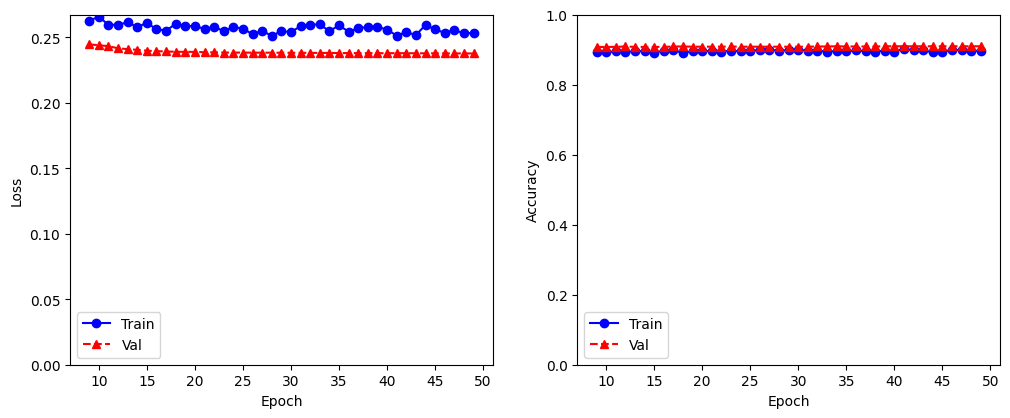

In [25]:
plot_metrics(history_ft)

# **Confusion Matrix Report**

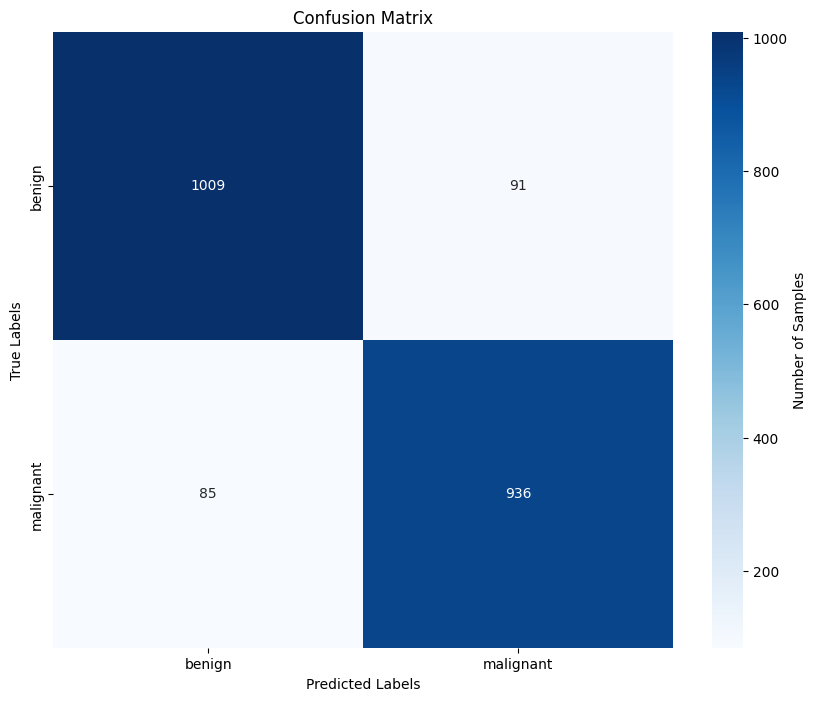

In [26]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

predictions = np.argmax(model.predict(test_ds, verbose=0), axis=-1)
labels = test_ds.labels

conf_matrix = tf.math.confusion_matrix(labels=labels, predictions=predictions)

# Convert TensorFlow tensor to NumPy array for visualization
conf_matrix_np = conf_matrix.numpy()

# Plot the confusion matrix using seaborn and matplotlib
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_np, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_ds.class_indices.keys(),  # Replace with your class names
            yticklabels=test_ds.class_indices.keys(),  # Replace with your class names
            cbar_kws={'label': 'Number of Samples'})
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# **Save model**

In [27]:
import time, os
import tensorflow as tf

MODEL_NAME = 'Skin_cancer'
MODEL_SAVE_PATH = f'{MODEL_NAME}'
model.save(f'{MODEL_SAVE_PATH}.h5')

# **Check save model**

In [28]:
loaded = tf.keras.models.load_model("Skin_cancer.h5")
loaded.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 efficientnetb1 (Functional  (None, 8, 8, 1280)        6575239   
 )                                                               
                                                                 
 gap (GlobalAveragePooling2  (None, 1280)              0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 prediction_output (Dense)   (None, 2)                 2562      
                                                                 
Total params: 6577801 (25.09 MB)
Trainable params: 6515746 (2

In [29]:
def _parse_fn_numpy(filename, label,IMAGE_SIZE=224):
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # img = img / 255.
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    return img, label

def make_inference(inputs):
    labeling = loaded.predict(inputs)
    return labeling


# **Predict Image**

1/1 [==============================] - 4s 4s/step


array([[0.9846, 0.0154]], dtype=float32)

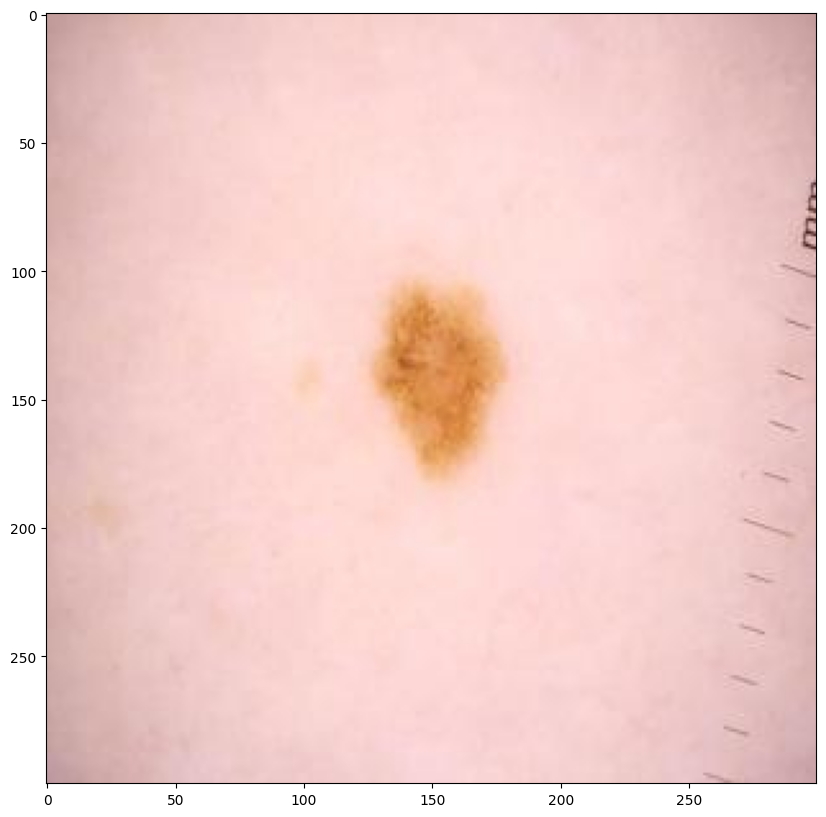

In [30]:
# Predict benign label
path = "/content/melanoma_cancer_dataset/train/benign/melanoma_0.jpg"

x_np, label = _parse_fn_numpy(path, 0, 240)
x_np = x_np[np.newaxis, :]

proba = make_inference(x_np.astype(np.float32))
plt.imshow(plt.imread(path))
proba

1/1 [==============================] - 0s 27ms/step


array([[0.0127, 0.9873]], dtype=float32)

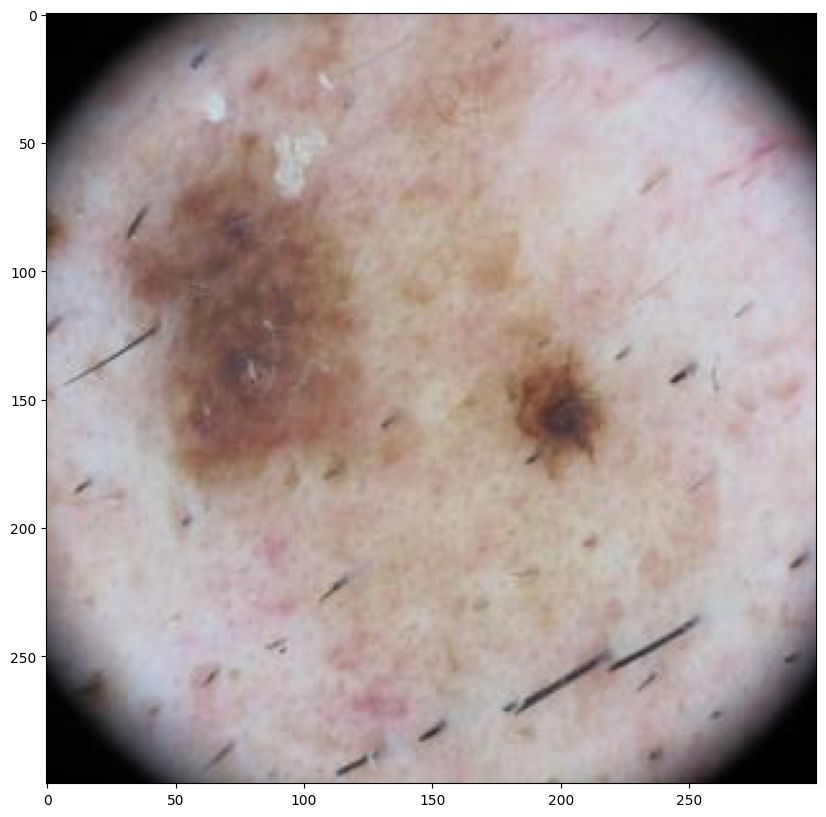

In [31]:
# Predict malignant label
path = "/content/melanoma_cancer_dataset/train/malignant/melanoma_5000.jpg"

x_np, label = _parse_fn_numpy(path, 0, 240)
x_np = x_np[np.newaxis, :]

proba = make_inference(x_np.astype(np.float32))
plt.imshow(plt.imread(path))
proba